In [1]:
import os
from m_libri_generator import get_file_dict_libri
import numpy as np
import torch.nn.functional as F
import torch
import random
import matplotlib.pyplot as plt
import tuneThreshold
import csv

In [2]:
# EMB_PATH = "../libri_emb/base/"
# EMB_PATH = "../libri_emb/trimmed/"
# EMB_PATH = "../libri_emb/uneval/"
EMB_PATH = "../libri_emb/dev-clean/"

In [3]:
npy_list = os.listdir(EMB_PATH)
npy_list = [i for i in npy_list if str.find(i, "npy") != -1]

spk_emb_dict = {}
for emb in npy_list:
    emb_spk = int(emb[3:-4])
    emb_mat = np.load(EMB_PATH+emb)
    
    emb_mat = torch.tensor(emb_mat)
    spk_emb_dict[emb_spk] = emb_mat

spk_list = list(spk_emb_dict.keys())

In [4]:
spk_npy_dict = {}
for spk in spk_list:
    structure_dict = {}
    csv_file = open(EMB_PATH+'op_{}.csv'.format(spk), 'r')
    csv_reader = csv.reader(csv_file)
    
    for row in csv_reader:
        wav_idx = int(row[0])
        wav_name = row[1]
        wav_cat = int(row[1].split('-')[1])
        
        cat_list = structure_dict.get(wav_cat, [])
        cat_list.append(wav_idx)
        structure_dict[wav_cat] = cat_list
    
    spk_npy_dict[spk] = structure_dict
    csv_file.close()

In [5]:
# 단일 발화 EER - original

def eer_original(iter=10, diff_cat_flag=False):
    d0_same = []
    d0_diff = []
    
    for i in range(iter):        
        for spk in spk_list:
            
            # same spk
            emb_mat = spk_emb_dict[spk]
            
            # 다른 카테고리 flag
            if diff_cat_flag:
                npy_dict = spk_npy_dict[spk]
                cats = list(npy_dict.keys())
                
                # 화자의 카테고리 수가 1인 경우, 다른 카테고리에서 두개 뽑는게 불가능하므로 넘김.
                if len(cats) == 1:
                    continue
                
                selected_cats = random.sample(cats, 2)
                cat_list1 = npy_dict[selected_cats[0]]
                cat_list2 = npy_dict[selected_cats[1]]
                
                indices = []
                indices.append(random.choice(cat_list1))
                indices.append(random.choice(cat_list2))
            
            else:
                indices = random.sample(range(emb_mat.shape[0]), 2)
            
            emb1 = emb_mat[indices[0]]
            emb2 = emb_mat[indices[1]]
            
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            d0_same.append(torch.cdist(emb1, emb2, p=2).mean().item())
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]]
            emb_mat2 = spk_emb_dict[indices[1]]
            emb1 = random.choice(emb_mat1)
            emb2 = random.choice(emb_mat2)
            
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            d0_diff.append(torch.cdist(emb1, emb2, p=2).mean().item())

    fig, ax = plt.subplots()
    plt.boxplot([d0_same, d0_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')
    plt.show()

    d0 = d0_same + d0_diff
    s0 = [-1*i for i in d0]
    label_same = np.ones(len(d0_same))
    label_diff = np.zeros(len(d0_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt0, eer0, fpr0, fnr0) = tuneThreshold.tuneThresholdfromScore(s0, label, [1, 0.1])
    
    return eer0

In [6]:
def eer_single_normalize(iter=10, flag=0, diff_cat_flag=False):
    '''
    flag(0): normalize before frame-by average
    flag(1): normalize after frame-by average
    '''
    assert flag == 0 or flag == 1
    
    d1_same = []
    d1_diff = []
    
    for i in range(iter):
        for spk in spk_list:

            # same spk
            emb_mat = spk_emb_dict[spk] # n_utter, 10, 512
            
            # 다른 카테고리 flag
            if diff_cat_flag:
                npy_dict = spk_npy_dict[spk]
                cats = list(npy_dict.keys())
                
                # 화자의 카테고리 수가 1인 경우, 다른 카테고리에서 두개 뽑는게 불가능하므로 넘김.
                if len(cats) == 1:
                    continue
                
                selected_cats = random.sample(cats, 2)
                cat_list1 = npy_dict[selected_cats[0]]
                cat_list2 = npy_dict[selected_cats[1]]
                
                indices = []
                indices.append(random.choice(cat_list1))
                indices.append(random.choice(cat_list2))
            
            else:
                indices = random.sample(range(emb_mat.shape[0]), 2)
            
                
            emb1 = emb_mat[indices[0]]
            emb2 = emb_mat[indices[1]]
            
            if flag == 0:                
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
            
            d1_same.append(torch.dist(emb1, emb2, p=2))
            
            
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]] # n_utter, 10, 512
            emb_mat2 = spk_emb_dict[indices[1]] # n_utter, 10, 512
            
            emb1 = random.choice(emb_mat1)
            emb2 = random.choice(emb_mat2)
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)     
            else:
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)      

            d1_diff.append(torch.dist(emb1, emb2, p=2))

    fig, ax = plt.subplots()
    plt.boxplot([d1_same, d1_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')

    plt.show()

    d1 = d1_same + d1_diff
    s1 = [-1*i for i in d1]
    label_same = np.ones(len(d1_same))
    label_diff = np.zeros(len(d1_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt1, eer1, fpr1, fnr1) = tuneThreshold.tuneThresholdfromScore(s1, label, [1, 0.1])
    
    return eer1

In [7]:
def eer_multiple_normalize(iter=10, flag=0, n_utter=3, diff_cat_flag=False):
    
    '''
    flag(0): normalize before frame-by average
    flag(1): normalize between frame-by average and utterance-by average
    flag(2): normalize after utterance-by average
    '''
    
    assert flag == 0 or flag == 1 or flag == 2
    
    d2_same = []
    d2_diff = []
    for i in range(iter):
        for spk in spk_list:
            
            # same spk
            emb_mat = spk_emb_dict[spk] # n_utter, 10, 512
            
            # 다른 카테고리 flag
            if diff_cat_flag:
                npy_dict = spk_npy_dict[spk]
                cats = list(npy_dict.keys())
                
                # 화자의 카테고리 수가 1인 경우, 다른 카테고리에서 두개 뽑는게 불가능하므로 넘김.
                if len(cats) == 1:
                    continue
                
                selected_cats = random.sample(cats, 2)
                cat_list1 = npy_dict[selected_cats[0]]
                cat_list2 = npy_dict[selected_cats[1]]
                indices1 = random.sample(cat_list1, n_utter)
                indices2 = random.sample(cat_list2, n_utter)
            
            else:
                indices = random.sample(range(emb_mat.shape[0]), 2*n_utter)
                indices1 = indices[0:n_utter]
                indices2 = indices[n_utter:2*n_utter]
            
            emb1 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices1)) # 3, 10, 512
            emb2 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices2)) # 3, 10, 512
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=2)
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=2)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
            elif flag == 1:
                emb1 = emb1.mean(dim=1)
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
                
            d2_same.append(torch.dist(emb1, emb2, p=2))
            
            # diff spk
            indices = random.sample(spk_list, 2)
            emb_mat1 = spk_emb_dict[indices[0]] # n_utter, 10, 512
            emb_mat2 = spk_emb_dict[indices[1]] # n_utter, 10, 512
            indices1 = random.sample(range(emb_mat1.shape[0]), n_utter)
            indices2 = random.sample(range(emb_mat2.shape[0]), n_utter)
            
            emb1 = torch.index_select(emb_mat1, dim=0, index=torch.tensor(indices1)) # 3, 10, 512
            emb2 = torch.index_select(emb_mat2, dim=0, index=torch.tensor(indices2)) # 3, 10, 512
            
            if flag == 0:
                emb1 = F.normalize(emb1, p=2, dim=2)
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=2)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
            elif flag == 1:
                emb1 = emb1.mean(dim=1)
                emb1 = F.normalize(emb1, p=2, dim=1)
                emb1 = emb1.mean(dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = F.normalize(emb2, p=2, dim=1)
                emb2 = emb2.mean(dim=0)
            else:
                emb1 = emb1.mean(dim=1)
                emb1 = emb1.mean(dim=0)
                emb1 = F.normalize(emb1, p=2, dim=0)
                emb2 = emb2.mean(dim=1)
                emb2 = emb2.mean(dim=0)
                emb2 = F.normalize(emb2, p=2, dim=0)
                
            d2_diff.append(torch.dist(emb1, emb2, p=2))
        
    fig, ax = plt.subplots()
    plt.boxplot([d2_same, d2_diff], positions=[1,0])
    ax.set_xlabel('Label')
    ax.set_ylabel('Distance')
    plt.show()


    d2 = d2_same + d2_diff
    s2 = [-1*i for i in d2]
    label_same = np.ones(len(d2_same))
    label_diff = np.zeros(len(d2_diff))
    label = list(np.concatenate([label_same, label_diff]))
    (tt2, eer2, fpr2, fnr2) = tuneThreshold.tuneThresholdfromScore(s2, label, [1, 0.1])
    
    
    return eer2

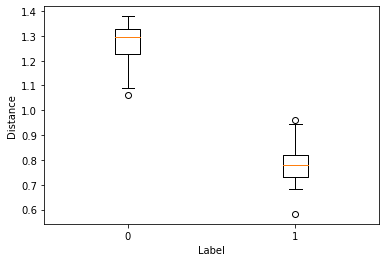

original method EER: 0.0


In [9]:
print("original method EER:", eer_original(iter=10, diff_cat_flag=False))
# print("original method EER:", eer_original(iter=10, diff_cat_flag=True))

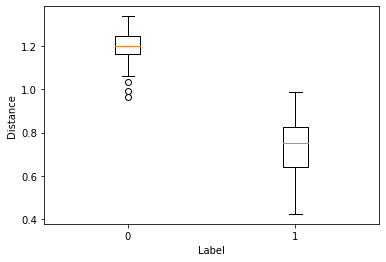

single method EER (normalize before average):  2.5


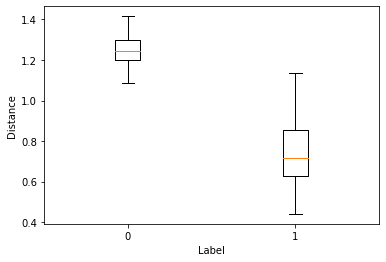

single method EER (normalize after average):  2.500000000000002


In [10]:
print("single method EER (normalize before average): ", eer_single_normalize(iter=10, flag=0))
print("single method EER (normalize after average): ", eer_single_normalize(iter=10, flag=1))

# print("single method EER (normalize before average): ", eer_single_normalize(iter=10, flag=0, diff_cat_flag=True))
# print("single method EER (normalize after average): ", eer_single_normalize(iter=10, flag=1, diff_cat_flag=True))

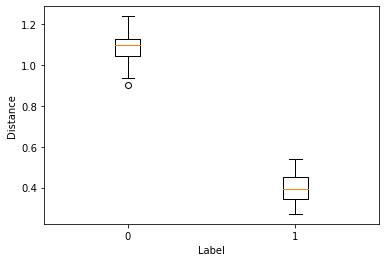

multiple method EER (normalize before frame-by avg):  0.0


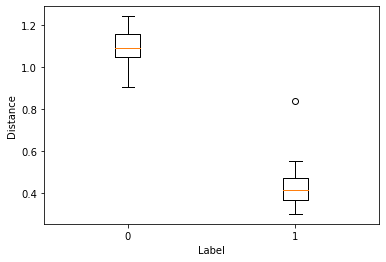

multiple method EER (normalize between frame-by avg and utter-by avg):  0.0


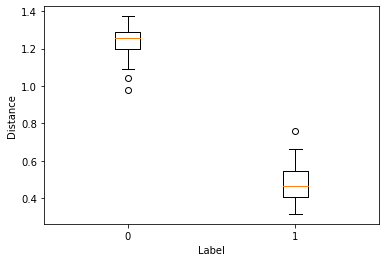

multiple method EER (normalize after utter-by avg):  0.0


In [11]:
print("multiple method EER (normalize before frame-by avg): ", eer_multiple_normalize(iter=10, flag=0, n_utter=3))
print("multiple method EER (normalize between frame-by avg and utter-by avg): ", eer_multiple_normalize(iter=10, flag=1, n_utter=3))
print("multiple method EER (normalize after utter-by avg): ", eer_multiple_normalize(iter=10, flag=2, n_utter=3))

# print("multiple method EER (normalize before frame-by avg): ", eer_multiple_normalize(iter=10, flag=0, n_utter=3, diff_cat_flag=True))
# print("multiple method EER (normalize between frame-by avg and utter-by avg): ", eer_multiple_normalize(iter=10, flag=1, n_utter=3, diff_cat_flag=True))
# print("multiple method EER (normalize after utter-by avg): ", eer_multiple_normalize(iter=10, flag=2, n_utter=3, diff_cat_flag=True))

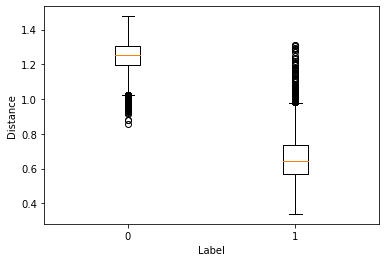

0.951396070320579


In [11]:
d1_same = []
d1_diff = []

same_info = []
same_emb = []

for i in range(10):
    for spk in spk_list:

        # same spk
        emb_mat = spk_emb_dict[spk] # n_utter, 10, 512
        
        # 다른 카테고리 flag
        if True:
            npy_dict = spk_npy_dict[spk]
            cats = list(npy_dict.keys())
            
            # 화자의 카테고리 수가 1인 경우, 다른 카테고리에서 두개 뽑는게 불가능하므로 넘김.
            if len(cats) == 1:
                continue
            
            selected_cats = random.sample(cats, 2)
            cat_list1 = npy_dict[selected_cats[0]]
            cat_list2 = npy_dict[selected_cats[1]]
            
            indices = []
            indices.append(random.choice(cat_list1))
            indices.append(random.choice(cat_list2))
        
        else:
            indices = random.sample(range(emb_mat.shape[0]), 2)
        
            
        emb1 = emb_mat[indices[0]]
        emb2 = emb_mat[indices[1]]
        same_emb.append((emb1, emb2))
        
        if False:
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            emb1 = emb1.mean(dim=0)
            emb2 = emb2.mean(dim=0)
        else:
            emb1 = emb1.mean(dim=0)
            emb2 = emb2.mean(dim=0)
            emb1 = F.normalize(emb1, p=2, dim=0)
            emb2 = F.normalize(emb2, p=2, dim=0)
        
        d1_same.append(torch.dist(emb1, emb2, p=2))
        same_info.append((spk, indices[0], spk, indices[1]))
        
        
        # diff spk
        indices = random.sample(spk_list, 2)
        emb_mat1 = spk_emb_dict[indices[0]] # n_utter, 10, 512
        emb_mat2 = spk_emb_dict[indices[1]] # n_utter, 10, 512
        
        # emb1 = random.choice(emb_mat1)
        # emb2 = random.choice(emb_mat2)
        indices2 = []
        indices2.append(random.choice(range(emb_mat1.shape[0])))
        indices2.append(random.choice(range(emb_mat2.shape[0])))
        emb1 = emb_mat1[indices2[0]]
        emb2 = emb_mat2[indices2[1]]
        
        if False:
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)
            emb1 = emb1.mean(dim=0)
            emb2 = emb2.mean(dim=0)     
        else:
            emb1 = emb1.mean(dim=0)
            emb2 = emb2.mean(dim=0)
            emb1 = F.normalize(emb1, p=2, dim=0)
            emb2 = F.normalize(emb2, p=2, dim=0)      

        d1_diff.append(torch.dist(emb1, emb2, p=2))
        # diff_idx.append((indices[0], indices2[0], indices[1], indices2[1]))

fig, ax = plt.subplots()
plt.boxplot([d1_same, d1_diff], positions=[1,0])
ax.set_xlabel('Label')
ax.set_ylabel('Distance')

plt.show()

d1 = d1_same + d1_diff
s1 = [-1*i for i in d1]
label_same = np.ones(len(d1_same))
label_diff = np.zeros(len(d1_diff))
label = list(np.concatenate([label_same, label_diff]))
(tt1, eer1, fpr1, fnr1) = tuneThreshold.tuneThresholdfromScore(s1, label, [1, 0.1])

print(eer1)

In [12]:
d1_same = np.array(d1_same)

Q1,Q3 = np.percentile(d1_same, [25, 75])
IQR = Q3-Q1

ul = Q3+1.5*IQR
ll = Q1-1.5*IQR
print(ul, ll, d1_same.shape, len(same_info))

outliers = np.where((d1_same > ul) | (d1_same < ll))
not_outliers = np.where((d1_same <= ul) & (d1_same >= ll))

outliers_dict = {}

for i in outliers[0]:
    info = same_info[i]
    outlier_idx = outliers_dict.get(info[0], [])
    outlier_idx.append((info[1], info[3]))
    outliers_dict[info[0]] = outlier_idx

out_spk = list(outliers_dict.keys())
out_idx = list(outliers_dict.values())
out_cnt = [len(i) for i in out_idx]

print(out_cnt)


0.9807243570685387 0.3241562470793724 (9670,) 9670
[1, 7, 2, 5, 3, 1, 2, 8, 1, 7, 9, 3, 1, 2, 1, 2, 1, 1, 6, 2, 1, 1, 1, 4, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
indices = sorted(range(len(out_cnt)), key=lambda k: -1*out_cnt[k])
print('Wrong classified people:', len(indices))
count = 0
for idx in indices:
    if out_cnt[idx] > 1:
        print(out_spk[idx], ':', out_cnt[idx], out_idx[idx])
        count += out_cnt[idx]

print('portion:', count/sum(out_cnt))


Wrong classified people: 71
118 : 9 [(5, 33), (7, 46), (28, 83), (37, 20), (4, 39), (27, 129), (16, 59), (52, 2), (35, 113)]
2269 : 8 [(88, 31), (19, 83), (89, 14), (27, 83), (32, 95), (77, 106), (94, 56), (90, 13)]
1988 : 7 [(45, 8), (34, 14), (4, 44), (48, 34), (33, 59), (60, 45), (13, 33)]
2074 : 7 [(93, 18), (109, 35), (84, 59), (79, 1), (106, 12), (92, 68), (61, 114)]
5802 : 6 [(73, 101), (102, 81), (45, 122), (107, 37), (87, 100), (122, 78)]
8183 : 5 [(8, 46), (13, 73), (22, 61), (43, 20), (95, 2)]
6574 : 4 [(97, 15), (83, 17), (69, 12), (19, 109)]
7850 : 3 [(48, 9), (10, 40), (42, 5)]
2277 : 3 [(40, 3), (87, 12), (82, 0)]
2060 : 2 [(79, 5), (79, 50)]
4039 : 2 [(33, 11), (37, 2)]
398 : 2 [(80, 0), (28, 123)]
251 : 2 [(43, 13), (13, 58)]
4640 : 2 [(59, 7), (13, 41)]
6319 : 2 [(3, 34), (47, 6)]
174 : 2 [(43, 29), (29, 10)]
6032 : 2 [(99, 42), (31, 105)]
6209 : 2 [(90, 63), (62, 111)]
1387 : 2 [(88, 74), (98, 17)]
portion: 0.5806451612903226
